In [2]:
import math
import numpy as np
import os
import pandas as pd
import pysurvival
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from statistics import mean, stdev

from pysurvival.utils.display import correlation_matrix
from pysurvival.models.survival_forest import RandomSurvivalForestModel
from pysurvival.utils.metrics import concordance_index, integrated_brier_score

from sklearn.model_selection import StratifiedKFold

from statsmodels.stats.outliers_influence import variance_inflation_factor

from lifelines import CoxPHFitter
import lifelines

In [ ]:
# Only need to run this once
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
utils.install_packages("survAUC")

### Feature Selection

In [4]:
def cox_feature_select(X, t, e):
    num_samples = X.shape[0]
    num_events = sum(e)

    data_table = X
    data_table['Time'] = t
    data_table['Event'] = e

    max_num_features = math.ceil(num_events/10)
    cph = CoxPHFitter()
    cph.fit(data_table, duration_col='Time', event_col='Event')

    hr = abs(cph.params_)
    
    filtered_hr = hr.nlargest(n=max_num_features, keep='first')
    index_names = filtered_hr.index

    col_names = []
    for x in range(1, len(index_names)):
        col_names.append(index_names[x])

    filtered_X = X.filter(items=col_names, axis=1)
    print("Cox filter remaining variables: \n", filtered_X.columns)

    return filtered_X

In [5]:
def calculate_vif(X, thresh=10):
    variables = list(range(X.shape[1]))
    dropped=True

    while dropped:
        dropped=False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix) \
               for ix in range(X.iloc[:, variables].shape[1])]
    
        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            # print("Dropping \'" + X.iloc[:, variables].columns[maxloc] + "\' at index: "+ str(maxloc))
            del variables[maxloc]
            dropped = True
    
    print('VIF remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]
        


### Model Creation and Training

In [6]:
def gh_c_index(risk_pred):
    """
    Calculate Gonen and Hiller's c-index using function from R (using rpy2) 

    Args:
        risk_pred: np.ndarray or torch.Tensor, risk score predictions from model

    Source: Gonen, M. and G. Heller (2005). 
    Concordance probability and discriminatory power in proportional hazards regression.
    Biometrika 92, 965–970.
    """

    # check for NaNs
    if not isinstance(risk_pred, np.ndarray):
        risk_pred = risk_pred.detach().cpu().numpy()
    for a in risk_pred:
        if np.isnan(a).any():
            raise ValueError("NaNs detected in inputs, please correct or drop.")

    # Use Gonen and Hiller's c-index via the survAUC library in R
    survAUC = rpackages.importr('survAUC')

    # Get data into right format
    R_risk_pred = robjects.vectors.FloatVector(risk_pred)

    # this doesn't work yet, need to get the list to numeric type
    # in R, this is accomplished with as.numeric and unlist()
    R_cind = survAUC.GHCI(R_risk_pred)

    # Convert back to Python list with single value
    cind = list(R_cind)

    # Return the only value in the cind list
    return cind[0]

In [7]:
def train_survival_model(X, t, e, num_trees, max_depth, min_node_size, seed=16):
    """
    Function to create and run Random Survival Forest with given attributes on data.

    Args:
        X: array -- input features, rows as samples
        t: array -- time labels for X, when event of interest or censoring occurred
        e: array -- event labels for X, if event occurred (1=event, 0=censoring)
        num_trees: int -- number of trees that will be built in forest model, used in initialization of model
        max_depth: int -- maximum number of levels allowed in tree, used in model fit
        min_node_size: int -- minimum number of samples required to be at leaf node, used in model fit
        seed: int -- random seed used by random number generator in model fit

    Returns: 
        rsf: pysurvival.model.RandomSurvivalForestModel -- model fit to input data
    """

    # Create instance of the model
    rsf = RandomSurvivalForestModel(num_trees=num_trees)

    # Fit model to data
    # Arguments not used from function input are defaults except importance_mode
    # TODO: need to find out what importance mode is 
    rsf.fit(X, t, e, max_features='all', max_depth=max_depth, min_node_size=min_node_size,
            num_threads=-1, sample_size_pct=0.63,
            seed=seed, save_memory=False)


    return rsf

In [33]:
def evaluate_forest(rsf, XT, tT, eT):
    
    risk = rsf.predict_risk(XT)
    # h_c_ind = lifelines.utils.concordance_index(tT, risk, eT)
    h_c_ind = concordance_index(rsf, XT, tT, eT)
    gh_c_ind = gh_c_index(risk)
    ibs = integrated_brier_score(rsf, XT, tT, eT)

    return h_c_ind, gh_c_ind, ibs, risk


In [9]:
def kfold_train_survival_model(X, t, e, num_trees, max_depth, min_node_size, k=5, seed=16):
    CI = []
    CPE = []
    IBS = []

    best_fold = 0
    best_CI = 0
    # best_GHCI = 0
    # best_IBS = 0 
    best_fold_rsf = None

    kf = StratifiedKFold(n_splits=k, random_state=seed, shuffle=True)

    history = {'train_CI': [], 'train_CPE': [], 'train_IBS': [], 
               'valid_CI': [], 'valid_CPE': [], 'valid_IBS': [],}
    for fold, (train_idx, val_idx) in enumerate(kf.split(X, e)):
        # Output current fold number
        # print('Fold {}'.format(fold + 1))

        X_train, X_val = X.loc[train_idx], X.loc[val_idx]
        t_train, t_val = t.loc[train_idx], t.loc[val_idx]
        e_train, e_val = e.loc[train_idx], e.loc[val_idx]

        fold_rsf = train_survival_model(X_train, t_train, e_train, num_trees, max_depth, min_node_size, seed)

        train_h_c_ind, train_cpe, train_ibs, _ = evaluate_forest(fold_rsf, X_train, t_train, e_train)
        val_h_c_ind, val_cpe, val_ibs, _ = evaluate_forest(fold_rsf, X_val, t_val, e_val)

        history['train_CI'].append(train_h_c_ind)
        history['train_CPE'].append(train_cpe)
        history['train_IBS'].append(train_ibs)
        history['valid_CI'].append(val_h_c_ind)
        history['valid_CPE'].append(val_cpe)
        history['valid_IBS'].append(val_ibs)

        if best_CI < val_h_c_ind:
            best_CI = val_h_c_ind
            best_fold = fold
            best_fold_rsf = fold_rsf

    
    train_CI_avg = mean(history['train_CI'])
    train_CI_std = stdev(history['train_CI'])
    train_GHCI_avg = mean(history['train_CPE'])
    train_GHCI_std = stdev(history['train_CPE'])
    train_IBS_avg = mean(history['train_IBS'])
    train_IBS_std = stdev(history['train_IBS'])

    valid_CI_avg = mean(history['valid_CI'])
    valid_CI_std = stdev(history['valid_CI'])
    valid_GHCI_avg = mean(history['valid_CPE'])
    valid_GHCI_std = stdev(history['valid_CPE'])
    valid_IBS_avg = mean(history['valid_IBS'])
    valid_IBS_std = stdev(history['valid_IBS'])



    avg_train_fold_results = {'CI_avg': train_CI_avg, 'CI_std': train_CI_std, 
                              'GHCI_avg': train_GHCI_avg, 'GHCI_std': train_GHCI_std,
                              'IBS_avg': train_IBS_avg, 'IBS_std': train_IBS_std}

    avg_valid_fold_results = {'CI_avg': valid_CI_avg, 'CI_std': valid_CI_std, 
                              'GHCI_avg': valid_GHCI_avg, 'GHCI_std': valid_GHCI_std,
                              'IBS_avg': valid_IBS_avg, 'IBS_std': valid_IBS_std}

    best_fold_results = {'train_CI': history['train_CI'][best_fold],
                         'train_CPE': history['train_CPE'][best_fold],
                         'train_IBS': history['train_IBS'][best_fold],
                         'valid_CI': history['valid_CI'][best_fold],
                         'valid_CPE': history['valid_CPE'][best_fold],
                         'valid_IBS': history['valid_IBS'][best_fold]}

    return avg_train_fold_results, avg_valid_fold_results, best_fold_results, best_fold_rsf

In [10]:
def gridsearch_survival_model(X, t, e, tree_search, depth_search, node_search):
    """
    Function to run a gridsearch on various Random Survival Forest hyperparameters

    Args:
        X: array -- input features, rows as samples
        t: array -- time labels for X, when event of interest or censoring occurred
        e: array -- event labels for X, if event occurred (1=event, 0=censoring)
    """
    # Values to search through
    num_tree=tree_search
    max_depth=depth_search
    min_node=node_search

    # initialize variables to store best options
    num_tree_best = 0
    max_depth_best = 0
    min_node_best = 0
    c_index_best = 0
    # ghci_best = 0
    avg_train_results = None
    avg_valid_results = None
    best_overall_results = None
    best_rsf = None


    for a in num_tree:
        for b in max_depth:
            for c in min_node:
                avg_train_fold_results, avg_valid_fold_results, best_fold_results, best_fold_rsf = \
                    kfold_train_survival_model(X, t, e, num_trees=a, max_depth=b, min_node_size=c, k=5, seed=16)
                # print(a, b, c, CI_avg)
                best_val_ci = best_fold_results['valid_CI']
                if best_val_ci > c_index_best:
                    c_index_best = best_val_ci
                    avg_train_results = avg_train_fold_results
                    avg_valid_results = avg_valid_fold_results
                    best_overall_results = best_fold_results
                    num_tree_best = a
                    max_depth_best = b
                    min_node_best = c
                    best_rsf = best_fold_rsf

    return num_tree_best, max_depth_best, min_node_best, avg_train_results, avg_valid_results, best_overall_results, best_rsf

# Main Script

### Liver

In [29]:
data_folder = "/Data/FeatureSelection/HCC_MCRC_ICC_HDFS_90_10/"

train_liver_data = pd.read_excel(os.path.join(data_folder, "train_liver_feats_and_labels.xlsx"))
test_liver_data = pd.read_excel(os.path.join(data_folder, "test_liver_feats_and_labels.xlsx"))

features_to_drop=[]
# features_to_drop = ['LeastAxisLength', '90Percentile', 'Contrast', 'MeshVolume', 'Complexity', 'MinorAxisLength', \
#                     '10Percentile', 'Uniformity', 'Mean', 'Energy', 'InterquartileRange', 'TotalEnergy', 'Busyness', \
#                     'RootMeanSquared', 'Maximum3DDiameter']

X_liver = train_liver_data.drop(labels=["ScoutID", "HDFS_Time", "HDFS_Code", "Cancer_Type"], axis=1)
X_liver = X_liver.drop(labels=features_to_drop, axis=1)
t_liver = train_liver_data["HDFS_Time"]
e_liver = train_liver_data["HDFS_Code"]

XT_liver = test_liver_data.drop(labels=["ScoutID", "HDFS_Time", "HDFS_Code", "Cancer_Type"], axis=1)
XT_liver = XT_liver.drop(labels=features_to_drop, axis=1)
tT_liver = test_liver_data["HDFS_Time"]
eT_liver = test_liver_data["HDFS_Code"]


# CI_avg, GHCI_avg, IBS_avg, best_CI, best_GHCI, best_IBS, best_fold_rsf = kfold_train_survival_model(\
#     X_liver, t_liver, e_liver, num_trees=5, max_depth=5, min_node_size=5, k=5, seed=16)


In [30]:
liver_vselected_features = calculate_vif(X_liver, 10)
X_liver = liver_vselected_features

X_liver = cox_feature_select(X_liver, t_liver, e_liver)


/opt/conda/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


VIF remaining variables:
Index(['Kurtosis', 'Skewness', 'Variance', 'Busyness', 'Coarseness',
       'Complexity', 'Contrast', 'Strength', 'Flatness', 'SurfaceArea'],
      dtype='object')
Cox filter remaining variables: 
 Index(['Contrast', 'Flatness', 'Strength', 'Skewness', 'Kurtosis', 'Busyness',
       'Complexity', 'Variance', 'SurfaceArea'],
      dtype='object')


/opt/conda/lib/python3.8/site-packages/lifelines/utils/__init__.py:1103: ConvergenceWarning: Column(s) ['Coarseness', 'Contrast'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


In [31]:
X_liver.drop(labels=['Contrast'], inplace=True, axis=1)
print(X_liver.columns)

Index(['Flatness', 'Strength', 'Skewness', 'Kurtosis', 'Busyness',
       'Complexity', 'Variance', 'SurfaceArea'],
      dtype='object')


In [34]:
num_tree=(5, 10, 15, 20, 25)
max_depth=(2, 4, 6, 8, 10)
min_node=(5, 8, 10, 12, 15)

liv_num_tree_best, liv_max_depth_best, liv_min_node_best, \
    liv_avg_train_results, liv_avg_valid_results, liv_best_overall_results, liv_best_fold_rsf \
        = gridsearch_survival_model(X_liver, t_liver, e_liver, num_tree, max_depth, min_node)

print("Best valid c-index:", liv_best_overall_results['valid_CI'])
# print("Best valid CPE", liv_best_overall_results['valid_CPE'])
print("Best num_tree val:",liv_num_tree_best)
print("Best max_depth val:", liv_max_depth_best)
print("Best min_node val:",liv_min_node_best)

# liver_rsf = train_survival_model(X_liver, t_liver, e_liver, num_trees=liv_num_tree_best, max_depth=liv_max_depth_best, min_node_size=liv_min_node_best, seed=16)

# train_liver_cind, train_liver_ghci, train_liver_ibs, train_liver_riskpred = evaluate_forest(liv__rsf, X_liver, t_liver, e_liver)

liver_h_c_ind, liver_gh_c_ind, liver_ibs, liver_riskpreds = evaluate_forest(liv_best_fold_rsf, XT_liver, tT_liver, eT_liver)

print("Training: ")
print("Harrel's C-index: ", liv_best_overall_results['train_CI'])
print("CPE: ", liv_best_overall_results['train_CPE'])
print("IBS: ", liv_best_overall_results['train_IBS'])
print()

print("Validation: ")
print("Harrel's C-index: ", liv_best_overall_results['valid_CI'])
print("CPE: ", liv_best_overall_results['valid_CPE'])
print("IBS: ", liv_best_overall_results['valid_IBS'])

print()
print("Testing: ")
print("Harrel's C-index: ", liver_h_c_ind)
print("GH C-index: ", liver_gh_c_ind)
print("IBS: ", liver_ibs)

liv_var_imps = liv_best_fold_rsf.variable_importance_table
liv_var_imps

Best valid c-index: 0.51484375
Best num_tree val: 5
Best max_depth val: 8
Best min_node val: 12
Training: 
Harrel's C-index:  0.2854995403384103
CPE:  0.9946024457924708
IBS:  0.19180639268088107

Validation: 
Harrel's C-index:  0.51484375
CPE:  0.9945234516910862
IBS:  0.2595744988089337

Testing: 
Harrel's C-index:  0.4670781893004115
GH C-index:  0.505111103151189
IBS:  0.24459736343723673


,feature,importance,pct_importance
0,Skewness,2.098586,0.229402
1,Strength,1.848579,0.202073
2,SurfaceArea,1.674633,0.183059
3,Variance,1.673570,0.182942
4,Flatness,0.922591,0.100851
5,Busyness,0.554465,0.060610
6,Kurtosis,0.375645,0.041063
7,Complexity,-0.995080,0.000000


In [18]:
print(tT_liver.shape)
print(eT_liver.shape)

(47,)

In [19]:
lifelines.utils.concordance_index(tT_liver, liver_riskpreds, eT_liver)

# l_cindex(tT_liver, XT_liver, eT_liver)

0.4609053497942387

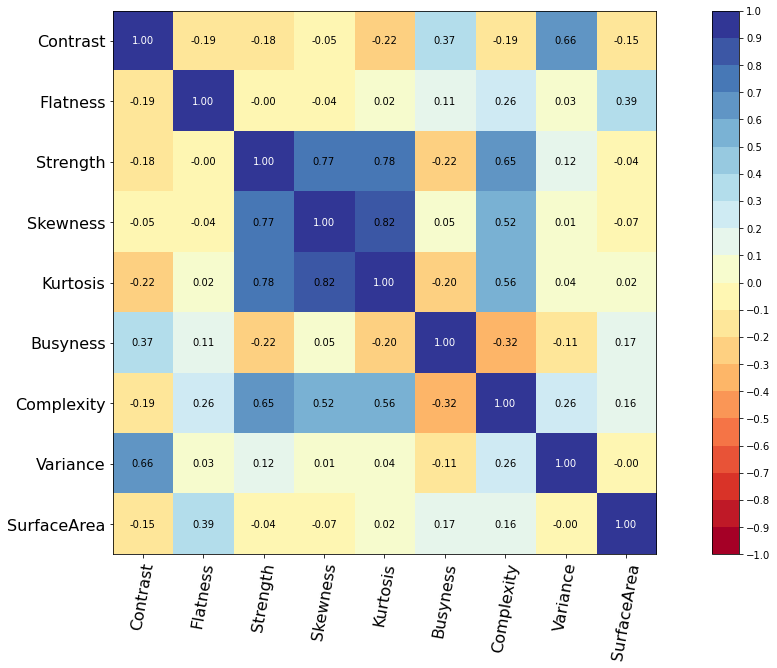

In [23]:
correlation_matrix(X_liver, figure_size=(20,10), text_fontsize=10)

In [24]:
test_liver_predictions = test_liver_data.loc[:, ['ScoutID', "HDFS_Time", "HDFS_Code", "Cancer_Type"]]
test_liver_predictions['Prediction'] = liver_riskpreds
test_liver_predictions.to_excel(os.path.join(data_folder, "RSF_test_liver_predictions_90_10_040822.xlsx"), index=False)

### Tumor

In [10]:
# Data Loading and Setup
data_folder = "/Data/FeatureSelection/HCC_MCRC_ICC_HDFS_90_10/"

train_tumor_data = pd.read_excel(os.path.join(data_folder, "train_tumor_feats_and_labels.xlsx"))
test_tumor_data = pd.read_excel(os.path.join(data_folder, "test_tumor_feats_and_labels.xlsx"))

features_to_drop = []
# features_to_drop = ['SurfaceVolumeRatio', 'Maximum2DDiameterSlice', 'MajorAxisLength', 'Busyness', 'VoxelVolume',\
                    # '90Percentile', 'Median', 'Energy', 'RootMeanSquared']

X_tumor = train_tumor_data.drop(labels=["ScoutID", "HDFS_Time", "HDFS_Code", "Cancer_Type"], axis=1)
X_tumor = X_tumor.drop(labels=features_to_drop, axis=1)
t_tumor = train_tumor_data["HDFS_Time"]
e_tumor = train_tumor_data["HDFS_Code"]

XT_tumor = test_tumor_data.drop(labels=["ScoutID", "HDFS_Time", "HDFS_Code", "Cancer_Type"], axis=1)
XT_tumor = XT_tumor.drop(labels=features_to_drop, axis=1)
tT_tumor = test_tumor_data["HDFS_Time"]
eT_tumor = test_tumor_data["HDFS_Code"]

In [11]:
# Feature selection
tum_vselected_features = calculate_vif(X_tumor, 10)
X_tumor = tum_vselected_features

X_tumor = cox_feature_select(X_tumor, t_tumor, e_tumor)


/opt/conda/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


VIF remaining variables:
Index(['10Percentile', 'Kurtosis', 'Minimum', 'TotalEnergy', 'Busyness',
       'Coarseness', 'Complexity', 'Contrast', 'Strength', 'Flatness',
       'Maximum2DDiameterColumn', 'MeshVolume'],
      dtype='object')
Cox filter remaining variables: 
 Index(['Contrast', 'Flatness', 'Strength', 'Maximum2DDiameterColumn',
       '10Percentile', 'Kurtosis', 'Busyness', 'Complexity', 'Minimum',
       'MeshVolume', 'TotalEnergy'],
      dtype='object')


/opt/conda/lib/python3.8/site-packages/lifelines/utils/__init__.py:1103: ConvergenceWarning: Column(s) ['Coarseness'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


In [12]:
X_tumor.drop(labels=['Minimum', 'Complexity', 'Strength','Busyness', 'Contrast', 'Flatness'], inplace=True, axis=1)
X_tumor.columns

Index(['Maximum2DDiameterColumn', '10Percentile', 'Kurtosis', 'MeshVolume',
       'TotalEnergy'],
      dtype='object')

In [13]:
tum_num_tree=(5, 8, 10, 12, 15)
tum_max_depth=(5, 8, 10, 12, 15)
tum_min_node=(5, 8, 10, 12, 15)
# RSF Model creation and evaluation
tum_num_tree_best, tum_max_depth_best, tum_min_node_best, \
    tum_avg_train_results, tum_avg_valid_results, tum_best_overall_results, tum_best_fold_rsf \
        = gridsearch_survival_model(X_tumor, t_tumor, e_tumor, tum_num_tree, tum_max_depth, tum_min_node)

print("Best k-fold c-index:", tum_best_overall_results['valid_CI'])
# print(ghci_best)
print("Best num_tree val:",tum_num_tree_best)
print("Best max_depth val:", tum_max_depth_best)
print("Best min_node val:",tum_min_node_best)

# tumor_rsf = train_survival_model(X_tumor, t_tumor, e_tumor, num_trees=tum_num_tree_best, max_depth=tum_max_depth_best, min_node_size=tum_min_node_best, seed=16)
# train_tumor_cind, train_tumor_ghci, train_tumor_ibs, train_tumor_riskpred = evaluate_forest(tumor_rsf, X_tumor, t_tumor, e_tumor)
tumor_h_c_ind, tumor_gh_c_ind, tumor_ibs, tumor_preds = evaluate_forest(tum_best_fold_rsf, XT_tumor, tT_tumor, eT_tumor)

print("Training: ")
print("Harrel's C-index: ", tum_best_overall_results['train_CI'])
print("CPE: ", tum_best_overall_results['train_CPE'])
print("IBS: ", tum_best_overall_results['train_IBS'])
print()

print("Validation: ")
print("Harrel's C-index: ", tum_best_overall_results['valid_CI'])
print("CPE: ", tum_best_overall_results['valid_CPE'])
print("IBS: ", tum_best_overall_results['valid_IBS'])

print()
print("Testing: ")
print("Harrel's C-index: ", tumor_h_c_ind)
print("GH C-index: ", tumor_gh_c_ind)
print("IBS: ", tumor_ibs)

tum_var_imps = tum_best_fold_rsf.variable_importance_table
tum_var_imps

/opt/conda/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/opt/conda/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Best k-fold c-index: 0.6898950914763523
Best num_tree val: 5
Best max_depth val: 5
Best min_node val: 12
Training: 
Harrel's C-index:  0.7017143301847929
CPE:  0.9912644913683765
IBS:  0.19769987125558175

Validation: 
Harrel's C-index:  0.6898950914763523
CPE:  0.9893375362179921
IBS:  0.19831096270338217

Testing: 
Harrel's C-index:  0.5865823163937233
GH C-index:  0.6333882161322358
IBS:  0.268526151621244


,feature,importance,pct_importance
0,Kurtosis,4.435464,0.602740
1,TotalEnergy,1.479777,0.201088
2,Maximum2DDiameterColumn,1.245096,0.169197
3,10Percentile,0.198503,0.026975
4,MeshVolume,-0.154732,0.000000


In [15]:
test_tumor_predictions = test_tumor_data.loc[:, ['ScoutID', "HDFS_Time", "HDFS_Code", "Cancer_Type"]]
test_tumor_predictions['Prediction'] = tumor_preds
test_tumor_predictions.to_excel(os.path.join(data_folder, "RSF_test_tumor_predictions_90_10_041122.xlsx"), index=False)

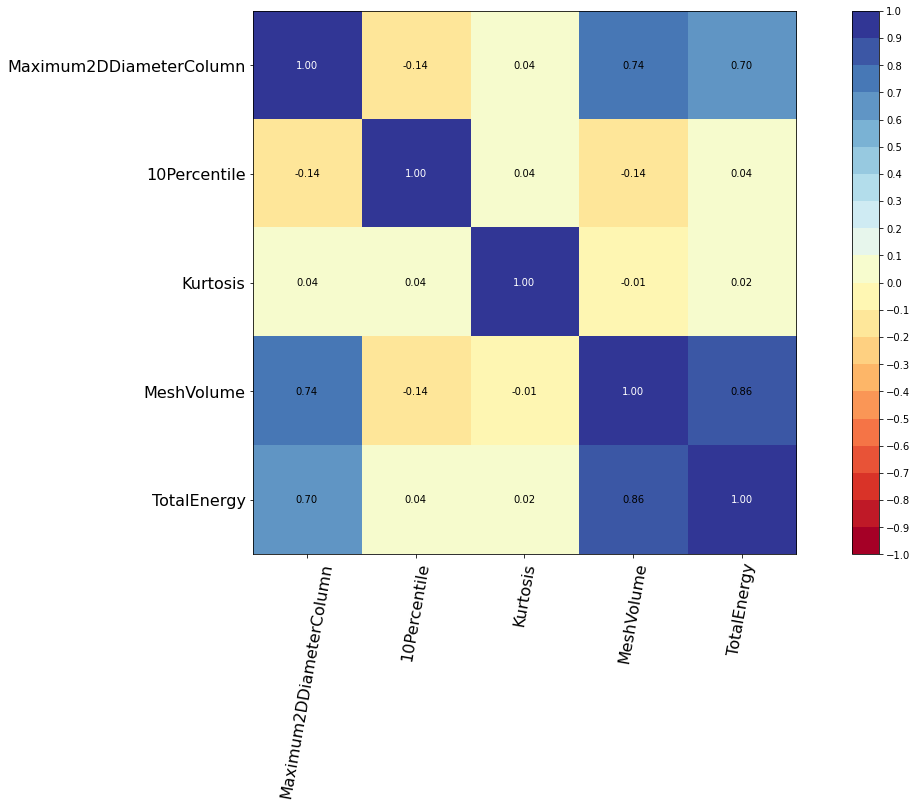

In [14]:
correlation_matrix(X_tumor, figure_size=(20,10), text_fontsize=10)

### Liver and Tumor

In [20]:
data_folder = "/Data/FeatureSelection/HCC_MCRC_ICC_HDFS_90_10/"

train_livertumor_data = pd.read_excel(os.path.join(data_folder, "train_liver_tumor_feats_and_labels.xlsx"))
test_livertumor_data = pd.read_excel(os.path.join(data_folder, "test_liver_tumor_feats_and_labels.xlsx"))

features_to_drop = []
# features_to_drop = ['Strength', 'MinorAxisLength', 'VoxelVolume', 'Complexity', 'Uniformity', 'Minimum', \
#                     'Median', 'InterquartileRange', 'Energy']

X_livertumor = train_livertumor_data.drop(labels=["ScoutID", "HDFS_Time", "HDFS_Code", "Cancer_Type"], axis=1)
X_livertumor = X_livertumor.drop(labels=features_to_drop, axis=1)
t_livertumor = train_livertumor_data["HDFS_Time"]
e_livertumor = train_livertumor_data["HDFS_Code"]

XT_livertumor = test_livertumor_data.drop(labels=["ScoutID", "HDFS_Time", "HDFS_Code", "Cancer_Type"], axis=1)
XT_livertumor = XT_livertumor.drop(labels=features_to_drop, axis=1)
tT_livertumor = test_livertumor_data["HDFS_Time"]
eT_livertumor = test_livertumor_data["HDFS_Code"]

In [21]:
livtum_vselected_features = calculate_vif(X_livertumor, 10)
X_livertumor = livtum_vselected_features

X_livertumor = cox_feature_select(X_livertumor, t_livertumor, e_livertumor)

/opt/conda/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


VIF remaining variables:
Index(['Kurtosis', 'Skewness', 'TotalEnergy', 'Variance', 'Busyness',
       'Complexity', 'Contrast', 'Strength', 'Flatness', 'SurfaceVolumeRatio'],
      dtype='object')
Cox filter remaining variables: 
 Index(['SurfaceVolumeRatio', 'Flatness', 'Skewness', 'Strength', 'Kurtosis',
       'Busyness', 'Complexity', 'Variance', 'TotalEnergy'],
      dtype='object')


/opt/conda/lib/python3.8/site-packages/lifelines/utils/__init__.py:1103: ConvergenceWarning: Column(s) ['Contrast'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


In [24]:
X_livertumor.drop(labels=['Busyness'], inplace=True, axis=1)

In [22]:
livtum_num_tree=(5, 10, 15, 20, 25)
livtum_max_depth=(2, 4, 6, 8, 10)
livtum_min_node=(5, 8, 10, 12, 15)


livtum_num_tree_best, livtum_max_depth_best, livtum_min_node_best, \
    livtum_avg_train_results, livtum_avg_valid_results, livtum_best_overall_results, livtum_best_fold_rsf \
        = gridsearch_survival_model(X_livertumor, t_livertumor, e_livertumor, livtum_num_tree, livtum_max_depth, livtum_min_node)

print("Best k-fold c-index:", livtum_best_overall_results['valid_CI'])
# print(ghci_best)
print("Best num_tree val:",livtum_num_tree_best)
print("Best max_depth val:",livtum_max_depth_best)
print("Best min_node val:",livtum_min_node_best)

# livertumor_rsf = train_survival_model(X_livertumor, t_livertumor, e_livertumor, num_trees=livtum_num_tree_best, max_depth=livtum_max_depth_best, min_node_size=livtum_min_node_best, seed=16)

# train_livertumor_cind, train_livertumor_ghci, train_livertumor_ibs, train_livertumor_riskpred = evaluate_forest(livertumor_rsf, X_livertumor, t_livertumor, e_livertumor)

livertumor_h_c_ind, livertumor_gh_c_ind, livertumor_ibs, livertumor_riskpreds = evaluate_forest(livtum_best_fold_rsf, XT_livertumor, tT_livertumor, eT_livertumor)

print("Training: ")
print("Harrel's C-index: ", livtum_best_overall_results['train_CI'])
print("CPE: ", livtum_best_overall_results['train_CPE'])
print("IBS: ", livtum_best_overall_results['train_IBS'])
print()

print("Validation: ")
print("Harrel's C-index: ", livtum_best_overall_results['valid_CI'])
print("CPE: ", livtum_best_overall_results['valid_CPE'])
print("IBS: ", livtum_best_overall_results['valid_IBS'])

print()
print("Testing: ")
print("Harrel's C-index: ",livertumor_h_c_ind)
print("GH C-index: ",livertumor_gh_c_ind)
print("IBS: ",livertumor_ibs)

var_imps = livtum_best_fold_rsf.variable_importance_table
var_imps

Best k-fold c-index: 0.6379402060149276
Best num_tree val: 25
Best max_depth val: 4
Best min_node val: 5
Training: 
Harrel's C-index:  0.7380751466286163
CPE:  0.9937444933550506
IBS:  0.19703330995085214

Validation: 
Harrel's C-index:  0.6379402060149276
CPE:  0.9942771694144877
IBS:  0.2363639579970837

Testing: 
Harrel's C-index:  0.6563633770616206
GH C-index:  0.8863330489136808
IBS:  0.23454251561657696


,feature,importance,pct_importance
0,Skewness,3.003978,0.429977
1,Strength,1.228272,0.175810
2,Variance,1.029485,0.147356
3,Complexity,0.969179,0.138724
4,SurfaceVolumeRatio,0.381560,0.054615
5,Kurtosis,0.181034,0.025912
6,TotalEnergy,0.114747,0.016424
7,Flatness,0.078119,0.011182
8,Busyness,-0.398760,0.000000


In [26]:
lifelines.utils.concordance_index(tT_livertumor, livertumor_riskpreds, eT_livertumor)

0.3381344307270233

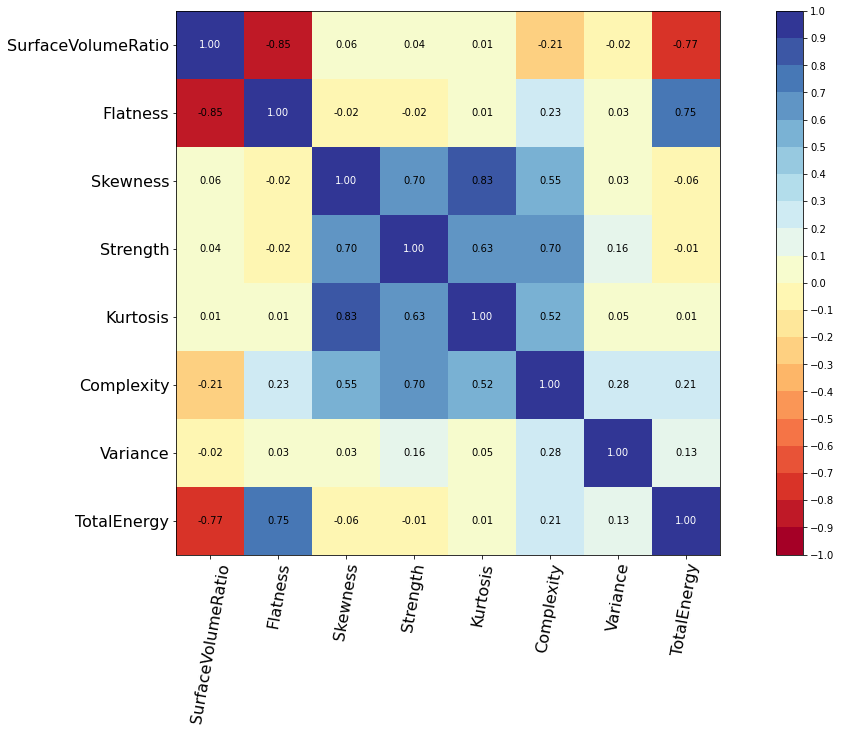

In [25]:
correlation_matrix(X_livertumor, figure_size=(20,10), text_fontsize=10)

In [21]:
test_livertumor_predictions = test_livertumor_data.loc[:, ['ScoutID', "HDFS_Time", "HDFS_Code", "Cancer_Type"]]
test_livertumor_predictions['Prediction'] = livertumor_riskpreds
test_livertumor_predictions.to_excel(os.path.join(data_folder, "RSF_test_liver_tumor_predictions_90_10_041122.xlsx"), index=False)

# Other Code

In [ ]:
# correlation_matrix(X_liver, figure_size=(30,15), text_fontsize=10)